In [2]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:33793")
client

<Client: 'tcp://127.0.0.1:33793' processes=8 threads=40, memory=157.36 GiB>

In [2]:
client.restart()

<Client: 'tcp://127.0.0.1:36877' processes=0 threads=0, memory=0 B>

In [3]:
import numpy as np
import xarray as xr
import xrft
import xwavelet
from scipy.stats import bootstrap
import os.path as op
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
ddir = '/tank/groups/climode/tuchida/pyqg-runs/'

In [5]:
N = 512
run = 0
if run == 2:
    ds = xr.open_zarr(op.join(ddir,'Two-layer-QG/N%04d/rd=100km_A1e-15_outputs%02d.zarr' 
                              % (N,run))
                     )
else:
    ds = xr.open_zarr(op.join(ddir,'Two-layer-QG/N%04d/rd=100km_A1e-15_outputs.zarr' % N)
                     )

ds = ds.isel(time=list(range(0,len(ds.time),3))
            ).sel(y=slice(200e3,800e3),x=slice(200e3,800e3)
                 )
ds

<xarray.Dataset>
Dimensions:            (time: 120, l: 512, k: 257, lev: 2, y: 308, x: 308,
                        lev_mid: 1)
Coordinates:
  * k                  (k) float64 0.0 6.283e-06 1.257e-05 ... 0.001602 0.001608
  * l                  (l) float64 0.0 6.283e-06 ... -1.257e-05 -6.283e-06
  * lev                (lev) int64 1 2
  * lev_mid            (lev_mid) float64 1.5
  * time               (time) float64 8.64e+05 8.64e+05 ... 8.64e+05 8.64e+05
  * x                  (x) float64 2.002e+05 2.021e+05 ... 7.979e+05 7.998e+05
  * y                  (y) float64 2.002e+05 2.021e+05 ... 7.979e+05 7.998e+05
Data variables: (12/33)
    APEflux            (time, l, k) float64 dask.array<chunksize=(1, 128, 257), meta=np.ndarray>
    APEgen             (time) float64 dask.array<chunksize=(120,), meta=np.ndarray>
    APEgenspec         (time, l, k) float64 dask.array<chunksize=(1, 128, 257), meta=np.ndarray>
    Dissspec           (time, l, k) float64 dask.array<chunksize=(1, 128, 257), meta=np.ndarray>
    EKE                (time, lev) float64 dask.array<chunksize=(1, 1), meta=np.ndarray>
    EKEdiss            (time) float64 dask.array<chunksize=(120,), meta=np.ndarray>
    ...                 ...
    u                  (time, lev, y, x) float64 dask.array<chunksize=(1, 1, 26, 26), meta=np.ndarray>
    ufull              (time, lev, y, x) float64 dask.array<chunksize=(1, 1, 26, 26), meta=np.ndarray>
    uh                 (time, lev, l, k) complex128 dask.array<chunksize=(1, 1, 128, 257), meta=np.ndarray>
    v                  (time, lev, y, x) float64 dask.array<chunksize=(1, 1, 26, 26), meta=np.ndarray>
    vfull              (time, lev, y, x) float64 dask.array<chunksize=(1, 1, 26, 26), meta=np.ndarray>
    vh                 (time, lev, l, k) complex128 dask.array<chunksize=(1, 1, 128, 257), meta=np.ndarray>
Attributes: (12/23)
    pyqg:L:          1000000.0
    pyqg:M:          262144
    pyqg:W:          1000000.0
    pyqg:beta:       0.0
    pyqg:del2:       0.8
    pyqg:delta:      0.25
    ...              ...
    pyqg:tavestart:  0.0
    pyqg:tc:         1440
    pyqg:tmax:       864000.0
    pyqg:twrite:     432000
    reference:       https://pyqg.readthedocs.io/en/latest/index.html
    title:           pyqg: Python Quasigeostrophic Model

In [6]:
L  = 1000e3
rd = 100e3
dx = L/N
delta = 0.25

z = 0
up = (ds.u).reset_coords(drop=True).isel(lev=z)
vp = (ds.v).reset_coords(drop=True).isel(lev=z)
qp = (ds.q).reset_coords(drop=True).isel(lev=z)
pp = (ds.p).reset_coords(drop=True).isel(lev=z)
up

<xarray.DataArray 'u' (time: 120, y: 308, x: 308)>
dask.array<getitem, shape=(120, 308, 308), dtype=float64, chunksize=(1, 128, 128), chunktype=numpy.ndarray>
Coordinates:
    lev      int64 1
  * time     (time) float64 8.64e+05 8.64e+05 8.64e+05 ... 8.64e+05 8.64e+05
  * x        (x) float64 2.002e+05 2.021e+05 2.041e+05 ... 7.979e+05 7.998e+05
  * y        (y) float64 2.002e+05 2.021e+05 2.041e+05 ... 7.979e+05 7.998e+05
Attributes:
    long_name:  zonal velocity anomaly
    units:      m s^-1

In [34]:
iso_csPQf = xrft.isotropic_cross_spectrum(
                    pp.chunk({'y':-1,'x':-1}), 
                    qp.chunk({'y':-1,'x':-1}), 
                    dim=["y", "x"], 
                    window='hann', 
                    window_correction=True, 
                    true_amplitude=True, truncate=True
            ).real

In [20]:
dsave = iso_csPQf.to_dataset(name='E')

if run == 2:
    dsave.to_zarr(op.join(ddir,'Two-layer-QG/N%04d/Fourier-TotE-spec_rd=100km-A1e-15_lev%1d_02_200-800.zarr' 
                          % (N,z)), mode='w')
else:
    dsave.to_zarr(op.join(ddir,'Two-layer-QG/N%04d/Fourier-TotE-spec_rd=100km-A1e-15_lev%1d_200-800.zarr' 
                          % (N,z)), mode='w')
print(dsave)
dsave.close()

<xarray.Dataset>
Dimensions:  (time: 120, freq_r: 54)
Coordinates:
    lev      int64 1
  * time     (time) float64 8.64e+05 8.64e+05 8.64e+05 ... 8.64e+05 8.64e+05
  * freq_r   (freq_r) float64 3.116e-06 7.314e-06 ... 0.0002468 0.0002515
Data variables:
    E        (time, freq_r) float64 dask.array<chunksize=(1, 54), meta=np.ndarray>


In [7]:
dsf = xr.concat([xr.open_zarr(op.join(ddir,
                            'Two-layer-QG/N%04d/Fourier-TotE-spec_rd=100km-A1e-15_lev0_200-800.zarr' % (N))),
                 xr.open_zarr(op.join(ddir,
                            'Two-layer-QG/N%04d/Fourier-TotE-spec_rd=100km-A1e-15_lev0_02_200-800.zarr' % (N)))
                ], 'time')

ntheta = 24
xo = rd

ssf = xr.DataArray(dsf.freq_r.data**-1/xo, dims=['scale'], 
                   coords={'scale':dsf.freq_r.data**-1/xo}
                  )
ss = xr.DataArray(np.linspace(2*dx,3*xo,30)/xo, dims=['scale'], 
                  coords={'scale':np.linspace(2*dx,5*xo,30)/xo}
                 )
ssh = xr.concat([ss.where(ss>50e3/xo).dropna('scale')[::-1],
                 ssf.where(ssf<50e3/xo).dropna('scale')],'scale')

In [36]:
iso_csPQw = xwavelet.wvlt_cross_spectrum(
                    pp, qp, ssh, dim=["y", "x"], xo=xo, ntheta=ntheta
            ).real

In [37]:
dsave = iso_csPQw.to_dataset(name='E')
if run == 2:
    dsave.chunk({'time':1,'angle':4}).to_zarr(op.join(ddir,
                                'Two-layer-QG/N%04d/Wavelet-TotE-spec_HighK_rd=100km-A1e-15_lev%1d_02_200-800.zarr'
                                                  % (N,z)), mode='w')
else:
    dsave.chunk({'time':1,'angle':4}).to_zarr(op.join(ddir,
                                'Two-layer-QG/N%04d/Wavelet-TotE-spec_HighK_rd=100km-A1e-15_lev%1d_200-800.zarr'
                                                  % (N,z)), mode='w')
print(dsave)
dsave.close()

<xarray.Dataset>
Dimensions:  (time: 120, angle: 12, scale: 75)
Coordinates:
    lev      int64 1
  * time     (time) float64 8.64e+05 8.64e+05 8.64e+05 ... 8.64e+05 8.64e+05
  * angle    (angle) float64 0.0 0.2618 0.5236 0.7854 ... 2.094 2.356 2.618 2.88
  * scale    (scale) float64 3e+05 2.898e+05 2.796e+05 ... 4.052e+03 3.976e+03
Data variables:
    E        (time, angle, scale) float64 dask.array<chunksize=(1, 12, 75), meta=np.ndarray>


In [49]:
iso_csPQwf = xwavelet.wvlt_cross_spectrum(
                    pp.chunk({'y':64,'x':64}), qp.chunk({'y':64,'x':64}), 
                    ssf, dim=["y", "x"], xo=xo, ntheta=ntheta
             ).real

In [7]:
dsave = iso_csPQwf.to_dataset(name='E')
if run == 2:
    dsave.chunk({'time':1,'angle':4}).to_zarr(op.join(ddir,
                    'Two-layer-QG/N%04d/Wavelet-TotE-spec_FourierK_rd=100km-A1e-15_lev%1d_02_200-800.zarr' 
                                                      % (N,z)), mode='w')
else:
    dsave.chunk({'time':1,'angle':4}).to_zarr(op.join(ddir,
                    'Two-layer-QG/N%04d/Wavelet-TotE-spec_FourierK_rd=100km-A1e-15_lev%1d_200-800.zarr' 
                                                      % (N,z)), mode='w')

print(dsave)
dsave.close()

NameError: name 'iso_csPQwf' is not defined

In [8]:
dsEw  = xr.concat([xr.open_zarr(op.join(ddir,
                            'Two-layer-QG/N%04d/Wavelet-TotE-spec_HighK_rd=100km-A1e-15_lev0_200-800.zarr' % (N))),
                  xr.open_zarr(op.join(ddir,
                            'Two-layer-QG/N%04d/Wavelet-TotE-spec_HighK_rd=100km-A1e-15_lev0_02_200-800.zarr' % (N)))
                 ], 'time')

dsEwf = xr.concat([xr.open_zarr(op.join(ddir,
                            'Two-layer-QG/N%04d/Wavelet-TotE-spec_FourierK_rd=100km-A1e-15_lev0_200-800.zarr' % (N))),
                  xr.open_zarr(op.join(ddir,
                           'Two-layer-QG/N%04d/Wavelet-TotE-spec_FourierK_rd=100km-A1e-15_lev0_02_200-800.zarr' % (N)))
                 ], 'time')

In [9]:
Ew   = (dsEw.E)
Ewf  = (dsEwf.E)
Ef   = (dsf.E)
# w3   = (Ew.mean(['angle']) / ((dsw.scale)**-1)**-3)
# w53  = (Ew.mean(['angle']) / ((dsw.scale)**-1)**(-5/3))
# wf3  = (Ewf.mean(['angle']) / ((dswf.scale)**-1)**-3)
# wf53 = (Ewf.mean(['angle']) / ((dswf.scale)**-1)**(-5/3))
# f3   = (Ef / (dsf.freq_r)**-3)
# f53  = (Ef / (dsf.freq_r)**(-5/3))

ValueError: x and y must have same first dimension, but have shapes (90,) and (240, 90)

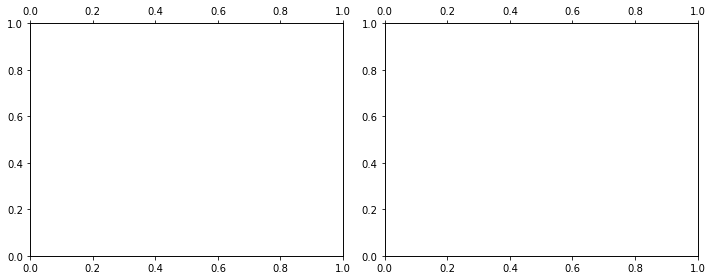

In [50]:
fig, (ax1,ax3) = plt.subplots(figsize=(10,4), nrows=1, ncols=2)
fig.set_tight_layout(True)
ax2 = ax1.twiny()
ax4 = ax3.twiny()

ax1.plot((dsf.freq_r)*1e3, 
         # .5*(dsf.U + dsf.V)*2*np.pi,
         -Ef*2*np.pi,
         'r', lw=2, label=r"Fourier")
ax1.plot((dsEwf.scale)**-1*1e3, 
         # .5*(dswf.U + dswf.V).sum(['angle'])*np.diff(dswf.angle)[0]*2,
         -Ewf.sum(['angle'])*np.diff(dswf.angle)[0]*2,
         'k--', label=r"Wavelet ($s_0 = k_F^{-1}$)")
ax1.plot((dsEw.scale)**-1*1e3, 
         # .5*(dsw.U + dsw.V).sum(['angle'])*np.diff(dsw.angle)[0]*2,
         -Ew.sum(['angle'])*np.diff(dsw.angle)[0]*2,
         'c:', lw=3, label=r"Wavelet")
ax1.plot((dswf.scale)**-1*1e3, ((dswf.scale/xo)**-1)**-3*5e1, 
         ls='--', c='grey', alpha=.8, label=r"$k^{-3}$")
ax1.plot((dswf.scale)**-1*1e3, ((dswf.scale/xo)**-1)**-(5/3)*1e2, 
         ls='-.', c='grey', alpha=.8, label=r"$k^{-5/3}$")

ax3.plot((dsf.freq_r)*1e3, f3/f3.min(),
         'r', label=r"")
ax3.plot((dsf.freq_r)*1e3, f53/f53.min(),
         'r--', label=r"")
ax3.plot((dswf.scale)**-1*1e3, wf3/wf3.min(),
         'k', label=r"$\alpha=-3$")
ax3.plot((dswf.scale)**-1*1e3, wf53/wf53.min(),
         'k--', label=r"$\alpha=-5/3$")
ax3.plot((dsw.scale)**-1*1e3, w3/w3.min(),
         c='c', lw=2, label=r"")
ax3.plot((dsw.scale)**-1*1e3, w53/w53.min(),
         c='c', ls='--', lw=2, label=r"")

ax1.set_xscale('log')
ax1.set_yscale('log')
ax3.set_xscale('log')

ax2.set_xscale('log')
ax2.set_yscale('log')
ax4.set_xscale('log')

ax1.set_ylim([1e-4,1.5e4])
# ax1.set_ylim([1e-7,1e2])
ax1.set_xlim([1.5e-3,3.5e-1])
ax3.set_xlim([1.5e-3,3.5e-1])
ax2.set_xlim([1.5e-3,3.5e-1])
ax4.set_xlim([1.5e-3,3.5e-1])
ax2.set_xticks([1e-2,1e-1])
ax2.set_xticklabels([1e2,1e1])
ax4.set_xticks([1e-2,1e-1])
ax4.set_xticklabels([1e2,1e1])
ax1.set_xlabel(r"[cpkm]", fontsize=13)
ax2.set_xlabel(r"[km]", fontsize=13)
ax1.set_ylabel(r"$E_K$ [(m$^2$ s$^{-2}$) / cpm]", fontsize=13)
ax3.set_xlabel(r"[cpkm]", fontsize=13)
ax4.set_xlabel(r"[km]", fontsize=13)
ax3.set_ylabel(r"$E_K~/~k^{\alpha}$", fontsize=13)
ax1.legend(loc='lower left', fontsize=12)
ax3.legend(loc='upper right', fontsize=12)
ax3.grid(True)
# plt.savefig(op.join(ddir,'Figs/WvsF_QG-lev%1d_KE-spec_A1e-15.pdf' % z))
plt.savefig(op.join(ddir,'Figs/WvsF_QG-lev%1d_TotE-spec_rd=100km-A1e-15_200-800.pdf' % z))

In [40]:
iso_psQw = xwavelet.wvlt_power_spectrum(
                    qp, ssh, dim=["y", "x"], xo=xo, ntheta=ntheta
           )

In [41]:
dsave = iso_psQw.to_dataset(name='Z')
if run == 2:
    dsave.to_zarr(op.join(ddir,
                    'Two-layer-QG/N%04d/Wavelet-Z-spec_HighK_rd=100km-A1e-15_lev%1d_02_200-800.zarr' 
                          % (N,z)), mode='w')
else:
    dsave.to_zarr(op.join(ddir,
                    'Two-layer-QG/N%04d/Wavelet-Z-spec_HighK_rd=100km-A1e-15_lev%1d_200-800.zarr' 
                          % (N,z)), mode='w')
print(dsave)
dsave.close()

<xarray.Dataset>
Dimensions:  (time: 120, angle: 12, scale: 75)
Coordinates:
    lev      int64 1
  * time     (time) float64 8.64e+05 8.64e+05 8.64e+05 ... 8.64e+05 8.64e+05
  * angle    (angle) float64 0.0 0.2618 0.5236 0.7854 ... 2.094 2.356 2.618 2.88
  * scale    (scale) float64 3e+05 2.898e+05 2.796e+05 ... 4.052e+03 3.976e+03
Data variables:
    Z        (time, angle, scale) float64 dask.array<chunksize=(1, 12, 75), meta=np.ndarray>


In [42]:
iso_psQf = xrft.isotropic_power_spectrum(
                    qp.chunk({'y':-1,'x':-1}), 
                    dim=["y", "x"], 
                    window='hann', 
                    window_correction=True, 
                    true_amplitude=True, truncate=True
           )

iso_psQwf = xwavelet.wvlt_power_spectrum(
                    qp, ssf, dim=["y", "x"], xo=xo, ntheta=ntheta
            )

In [43]:
dsave = iso_psQf.to_dataset(name='Z')
if run == 2:
    dsave.to_zarr(op.join(ddir,
                    'Two-layer-QG/N%04d/Fourier-Z-spec_rd=100km-A1e-15_lev%1d_02_200-800.zarr' 
                          % (N,z)), mode='w')
else:
    dsave.to_zarr(op.join(ddir,
                'Two-layer-QG/N%04d/Fourier-Z-spec_rd=100km-A1e-15_lev%1d_200-800.zarr' 
                      % (N,z)), mode='w')
print(dsave)
dsave.close()

dsave = iso_psQwf.to_dataset(name='Z')
if run == 2:
    dsave.chunk({'angle':4}).to_zarr(op.join(ddir,
                'Two-layer-QG/N%04d/Wavelet-Z-spec_FourierK_rd=100km-A1e-15_lev%1d_02_200-800.zarr' 
                      % (N,z)), mode='w')
else:
    dsave.chunk({'angle':4}).to_zarr(op.join(ddir,
                'Two-layer-QG/N%04d/Wavelet-Z-spec_FourierK_rd=100km-A1e-15_lev%1d_200-800.zarr' 
                      % (N,z)), mode='w')
print(dsave)
dsave.close()

<xarray.Dataset>
Dimensions:  (time: 120, freq_r: 54)
Coordinates:
    lev      int64 1
  * time     (time) float64 8.64e+05 8.64e+05 8.64e+05 ... 8.64e+05 8.64e+05
  * freq_r   (freq_r) float64 3.116e-06 7.314e-06 ... 0.0002468 0.0002515
Data variables:
    Z        (time, freq_r) float64 dask.array<chunksize=(1, 54), meta=np.ndarray>
<xarray.Dataset>
Dimensions:  (time: 120, angle: 12, scale: 54)
Coordinates:
    lev      int64 1
  * time     (time) float64 8.64e+05 8.64e+05 8.64e+05 ... 8.64e+05 8.64e+05
  * angle    (angle) float64 0.0 0.2618 0.5236 0.7854 ... 2.094 2.356 2.618 2.88
  * scale    (scale) float64 3.209e+05 1.367e+05 ... 4.052e+03 3.976e+03
Data variables:
    Z        (time, angle, scale) float64 dask.array<chunksize=(1, 12, 54), meta=np.ndarray>


In [10]:
dsZf = xr.concat([xr.open_zarr(op.join(ddir,
                        'Two-layer-QG/N%04d/Fourier-Z-spec_rd=100km-A1e-15_lev0_200-800.zarr' % (N))),
                 xr.open_zarr(op.join(ddir,
                        'Two-layer-QG/N%04d/Fourier-Z-spec_rd=100km-A1e-15_lev0_02_200-800.zarr' % (N)))
                ], 'time')

dsZw  = xr.concat([xr.open_zarr(op.join(ddir,
                            'Two-layer-QG/N%04d/Wavelet-Z-spec_HighK_rd=100km-A1e-15_lev0_200-800.zarr' % (N))),
                  xr.open_zarr(op.join(ddir,
                            'Two-layer-QG/N%04d/Wavelet-Z-spec_HighK_rd=100km-A1e-15_lev0_02_200-800.zarr' % (N)))
                 ], 'time')

dsZwf = xr.concat([xr.open_zarr(op.join(ddir,
                            'Two-layer-QG/N%04d/Wavelet-Z-spec_FourierK_rd=100km-A1e-15_lev0_200-800.zarr' % (N))),
                  xr.open_zarr(op.join(ddir,
                            'Two-layer-QG/N%04d/Wavelet-Z-spec_FourierK_rd=100km-A1e-15_lev0_02_200-800.zarr' % (N)))
                 ], 'time')

In [11]:
Zw  = (dsZw.Z)
Zwf = (dsZwf.Z)
Zf  = (dsZf.Z)
# w1  = (.5*(Zw).mean(['angle']) / ((dsw.scale)**-1)**-1)
# wf1 = (.5*(Zwf).mean(['angle']) / ((dswf.scale)**-1)**-1)
# f1  = (.5*(Zf) / (dsf.freq_r)**-1)

In [12]:
datas = (-Ew.sum('angle')
         * np.diff(dsEw.angle)[0]*2*1e3,)  # samples must be in a sequence
rng = np.random.default_rng()
Ewc  = bootstrap(datas, np.mean, confidence_level=0.95,
                random_state=rng
               )

datas = (-Ef * 2*np.pi*1e3,)  # samples must be in a sequence
rng = np.random.default_rng()
Efc  = bootstrap(datas, np.mean, confidence_level=0.95,
                random_state=rng
               )
########################
datas = (Zw.sum('angle')
         * np.diff(dsZw.angle)[0]*2*1e3,)  # samples must be in a sequence
rng = np.random.default_rng()
Zwc  = bootstrap(datas, np.mean, confidence_level=0.95,
                random_state=rng
               )

datas = (Zf * 2*np.pi*1e3,)  # samples must be in a sequence
rng = np.random.default_rng()
Zfc  = bootstrap(datas, np.mean, confidence_level=0.95,
                random_state=rng
               )

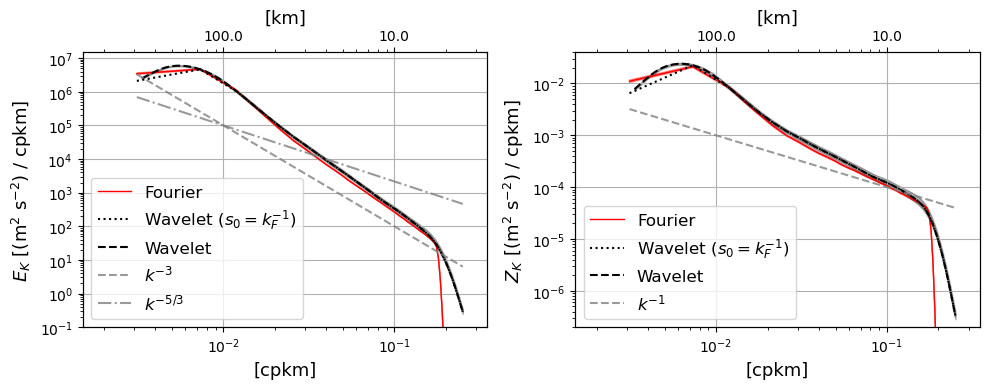

In [16]:
fig, (ax1,ax3) = plt.subplots(figsize=(10,4), nrows=1, ncols=2)
fig.set_tight_layout(True)
ax2 = ax1.twiny()
ax4 = ax3.twiny()

ax1.fill_between(dsf.freq_r*1e3, 
                 Efc.confidence_interval.low, Efc.confidence_interval.high, 
                 alpha=.4, color='r')
ax1.fill_between((dsEw.scale)**-1*1e3, 
                 Ewc.confidence_interval.low, Ewc.confidence_interval.high, 
                 alpha=.3, color='k')

ax1.plot((dsf.freq_r)*1e3, 
         # .5*(dsf.U + dsf.V)*2*np.pi,
         -Ef.mean('time')*2*np.pi*1e3,
         'r', lw=1, label=r"Fourier")
ax1.plot((dsEwf.scale)**-1*1e3, 
         # .5*(dswf.U + dswf.V).sum(['angle'])*np.diff(dswf.angle)[0]*2,
         -Ewf.mean('time').sum(['angle'])*np.diff(dsEwf.angle)[0]*2*1e3,
         'k:', label=r"Wavelet ($s_0 = k_F^{-1}$)")
ax1.plot((dsEw.scale)**-1*1e3, 
         # .5*(dsw.U + dsw.V).sum(['angle'])*np.diff(dsw.angle)[0]*2,
         -Ew.mean('time').sum(['angle'])*np.diff(dsEw.angle)[0]*2*1e3,
         'k--', label=r"Wavelet")
ax1.plot((dsEwf.scale)**-1*1e3, ((dsEwf.scale/xo)**-1)**-3*1e5, 
         ls='--', c='grey', alpha=.8, label=r"$k^{-3}$")
ax1.plot((dsEwf.scale)**-1*1e3, ((dsEwf.scale/xo)**-1)**-(5/3)*1e5, 
         ls='-.', c='grey', alpha=.8, label=r"$k^{-5/3}$")


ax3.fill_between(dsf.freq_r*1e3, 
                 Zfc.confidence_interval.low, Zfc.confidence_interval.high, 
                 alpha=.4, color='r')
ax3.fill_between((dsZw.scale)**-1*1e3, 
                 Zwc.confidence_interval.low, Zwc.confidence_interval.high, 
                 alpha=.3, color='k')

ax3.plot((dsZf.freq_r)*1e3, 
         # .5*(iso_psQf)*2*np.pi,
         Zf.mean('time')*2*np.pi*1e3,
         'r', lw=1, label=r"Fourier")
ax3.plot((dsZwf.scale)**-1*1e3, 
         # .5*(iso_psQwf).sum(['angle'])*np.diff(iso_psQwf.angle)[0]*2,
         Zwf.mean('time').sum(['angle'])*np.diff(dsZwf.angle)[0]*2*1e3,
         'k:', label=r"Wavelet ($s_0 = k_F^{-1}$)")
ax3.plot((dsZw.scale)**-1*1e3, 
         # .5*(iso_psQw).sum(['angle'])*np.diff(iso_psQw.angle)[0]*2,
         Zw.mean('time').sum(['angle'])*np.diff(dsZw.angle)[0]*2*1e3,
         'k--', label=r"Wavelet")
ax3.plot((dsZwf.scale)**-1*1e3, ((Zwf.scale/xo)**-1)**-1*1e-3, 
         ls='--', c='grey', alpha=.8, label=r"$k^{-1}$")

ax1.set_xscale('log')
ax1.set_yscale('log')
ax3.set_xscale('log')
ax3.set_yscale('log')

ax2.set_xscale('log')
# ax2.set_yscale('log')
ax4.set_xscale('log')

ax1.set_ylim([1e-1,1.5e7])
ax3.set_ylim([2e-7,4e-2])
ax1.set_xlim([1.5e-3,3.5e-1])
ax3.set_xlim([1.5e-3,3.5e-1])
ax2.set_xlim([1.5e-3,3.5e-1])
ax4.set_xlim([1.5e-3,3.5e-1])
ax2.set_xticks([1e-2,1e-1])
ax2.set_xticklabels([1e2,1e1])
ax4.set_xticks([1e-2,1e-1])
ax4.set_xticklabels([1e2,1e1])
ax1.set_xlabel(r"[cpkm]", fontsize=13)
ax2.set_xlabel(r"[km]", fontsize=13)
ax1.set_ylabel(r"$E_K$ [(m$^2$ s$^{-2}$) / cpkm]", fontsize=13)
ax3.set_xlabel(r"[cpkm]", fontsize=13)
ax4.set_xlabel(r"[km]", fontsize=13)
ax3.set_ylabel(r"$Z_K$ [(m$^2$ s$^{-2}$) / cpkm]", fontsize=13)
ax1.legend(loc='lower left', fontsize=12)
ax3.legend(loc='lower left', fontsize=12)
ax1.grid(True)
ax3.grid(True)
# plt.savefig(op.join(ddir,'Figs/WvsF_QG-lev%1d_KE-spec_A1e-15.pdf' % z))
plt.savefig(op.join(ddir,'Figs/WvsF_QG-lev%1d_TotE_Z-spec_rd=100km-A1e-15_200-800.pdf' % z))

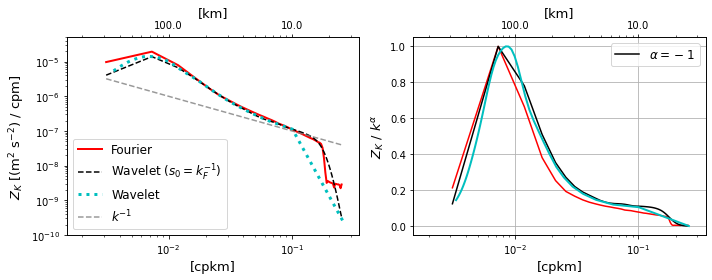

In [30]:
fig, (ax1,ax3) = plt.subplots(figsize=(10,4), nrows=1, ncols=2)
fig.set_tight_layout(True)
ax2 = ax1.twiny()
ax4 = ax3.twiny()
ax1.plot((dsf.freq_r)*1e3, 
         # .5*(iso_psQf)*2*np.pi,
         Zf*2*np.pi,
         'r', lw=2, label=r"Fourier")
ax1.plot((dswf.scale)**-1*1e3, 
         # .5*(iso_psQwf).sum(['angle'])*np.diff(iso_psQwf.angle)[0]*2,
         Zwf.sum(['angle'])*np.diff(dswf.angle)[0]*2,
         'k--', label=r"Wavelet ($s_0 = k_F^{-1}$)")
ax1.plot((dsw.scale)**-1*1e3, 
         # .5*(iso_psQw).sum(['angle'])*np.diff(iso_psQw.angle)[0]*2,
         Zw.sum(['angle'])*np.diff(dsw.angle)[0]*2,
         'c:', lw=3, label=r"Wavelet")
ax1.plot((dswf.scale)**-1*1e3, ((Zwf.scale/xo)**-1)**-1*1e-6, 
         ls='--', c='grey', alpha=.8, label=r"$k^{-1}$")

ax3.plot((dsf.freq_r)*1e3, f1/f1.max(),
         'r', label=r"")
ax3.plot((dswf.scale)**-1*1e3, wf1/wf1.max(),
         'k', label=r"$\alpha=-1$")
ax3.plot((dsw.scale)**-1*1e3, w1/w1.max(),
         c='c', lw=2)

ax1.set_xscale('log')
ax1.set_yscale('log')
ax3.set_xscale('log')

ax2.set_xscale('log')
ax2.set_yscale('log')
ax4.set_xscale('log')

ax1.set_xlim([1.5e-3,3.5e-1])
ax3.set_xlim([1.5e-3,3.5e-1])
ax1.set_ylim([1e-10,5e-5])
ax2.set_xlim([1.5e-3,3.5e-1])
ax4.set_xlim([1.5e-3,3.5e-1])
ax2.set_xticks([1e-2,1e-1])
ax2.set_xticklabels([1e2,1e1])
ax4.set_xticks([1e-2,1e-1])
ax4.set_xticklabels([1e2,1e1])
ax1.set_xlabel(r"[cpkm]", fontsize=13)
ax2.set_xlabel(r"[km]", fontsize=13)
ax1.set_ylabel(r"$Z_K$ [(m$^2$ s$^{-2}$) / cpm]", fontsize=13)
ax3.set_xlabel(r"[cpkm]", fontsize=13)
ax4.set_xlabel(r"[km]", fontsize=13)
ax3.set_ylabel(r"$Z_K~/~k^{\alpha}$", fontsize=13)
ax1.legend(loc='lower left', fontsize=12)
ax3.legend(loc='upper right', fontsize=12)
ax3.grid(True)
# plt.savefig(op.join(ddir,'Figs/WvsF_QG-lev%1d_Ens-spec_A1e-15.pdf' % z))
plt.savefig(op.join(ddir,'Figs/WvsF_QG-lev%1d_Ens-spec_rd=100km-A1e-15_200-800.pdf' % z))